# Apertures

Our aim will be to calculate instrumental magnitudes, i.e. magnitudes calculated from our data set but not calibrated to the outside world. Then, by comparing to standard stars, we will calibrate our photometric system. We will use aperture photometry to calculate the magnitudes needed for these steps.

These tasks will guide you through aperture photometry with the PHOTUTILS package. These tasks should be performed on the overscan subtracted, trimmed, bias subtracted, flat fielded science frames. 

Although the outline for the <a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/tree/master/notebooks/photometry">Github tutorials</a> we have been using extends to aperture photometry, they are not yet complete. The examples and documentation for aperture photometry with PHOTUTILS and some extra tools for finding stars in images are here instead:

<a href="https://photutils.readthedocs.io/en/stable/aperture.html">Aperture photometry with PHOTUTILS</a> <br>
<a href="https://photutils.readthedocs.io/en/stable/detection.html">Star finder</a> <br>

In [2]:
!pip install photutils

     |████████████████████████████████| 847 kB 1.9 MB/s eta 0:00:01


In general, the aim of aperture photometry is to characterize the signal from a source in an aperture. However, the pixels that recorded the source signal also record the background. Thus, the total signal is:

$S = T+AB$

$S$ - the total signal in the aperture <br>
$T$ - the total signal from the source in the aperture <br>
$A$ - the total number of background pixels in the aperture <br>
$B$ - the average background signal per pixel <br>

In [3]:
# import block
import numpy as np
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from pathlib import Path
import os
from scipy import stats
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from astropy.nddata import CCDData, StdDevUncertainty

In [4]:
# grab show_image
phot_tutorial_dir = '/home/kyle/Homework/Astro8060/ccd-reduction-and-photometry-guide/notebooks'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [5]:
# plotting defaults
# Use custom style for larger fonts and figures
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [7]:
# define directories
reduced_dir = '/mnt/chromeos/removable/ChromeSD/NoBackupImages/reduced/bias&trim/' # working directory

## 1. Find a practice star in a V-band image of the PG1633+099 field

PG1633+099 is a Landolt standard field, meaning that via very careful measurements, the magnitudes of many stars in this field are well known. Load up a085otzf.fits to practice on. 

In [10]:
data = CCDData.read(reduced_dir+'a085ot.fits').data

Also open the same frame in DS9. Choose a star to practice apertures and find its position in DS9. You can centroid an aperture in DS9 to get more accurate values than your cursor.

Edit>Region <br>
Click on a star near the center of the field and a green circle will appear. <br>
Double click inside the circle to edit the region's properties. <br>
Set radius to 15. <br>
Region>Centroid <br>
Double click inside the circle again to see the new x and y positions. <br>

You could also do this in Python with a 2D Gaussian fit.

In [11]:
# this will choose three dummy positions all centered at [0,0]
# you can choose more or fewer positions by adding/removing x,y pairs
# insert the position of a star from DS9 from the notes above
x1 = 1253
x2 = 1366
x3 = 1445
y1 = 1223
y2 = 1232
y3 = 1183
positions = [(x1,y1),(x2,y2),(x3,y3)]

## Create two apertures and plot them over the image

Create a circular aperture at the position of the star with a radius of 4 pixels. Also create a circular annulus with an inner radius of 10 pixels and an outer radius of 15 pixels.

In [51]:
circ_aperture    = CircularAperture(positions, r=8)
annulus_aperture = CircularAnnulus(positions, r_in=20, r_out=30)

Now display the a085 frame and plot your apertures over it in two different colors.

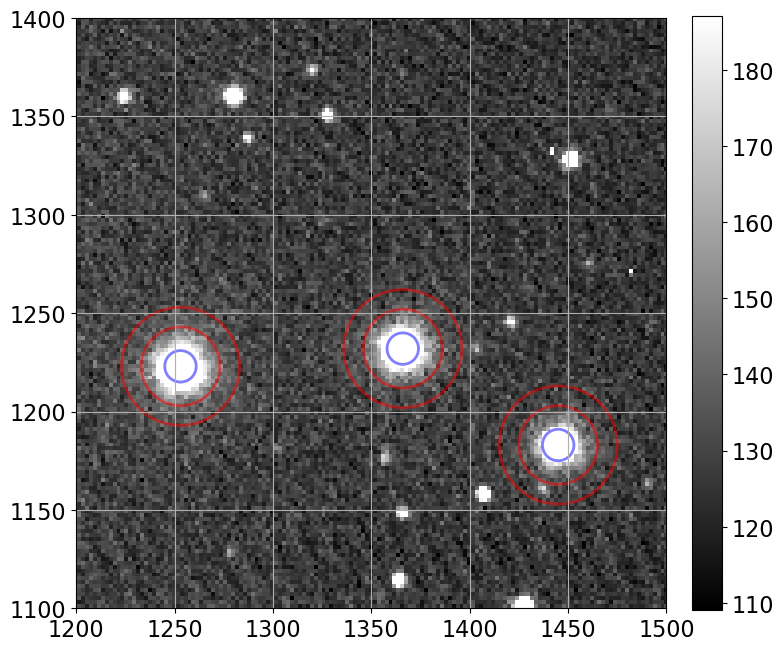

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(data, cmap='gray', ax=ax, fig=fig)
circ_aperture.plot(color='blue', lw=2, alpha=0.5)         # apertures

# add the annulus
annulus_aperture.plot(color='red',lw=2,alpha=0.5)

ax.set_xlim([1200,1500]) # use these to zoom in/out
ax.set_ylim([1100,1400])
plt.tight_layout()
plt.show()

## Calculate the total signal, $S$

In [53]:
phot_table = aperture_photometry(data, circ_aperture)
print(phot_table)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1  1253.0  1223.0 1075050.6498337267
  2  1366.0  1232.0  850023.8487270944
  3  1445.0  1183.0  589327.2654610774


## Calculate the number of pixels in the circular aperture, $A$

This is done for you with the aperture.area feature. Try printing this, and compare to $\pi r^2$ for your input radius.

In [54]:
print(circ_aperture.area)

201.06192982974676


## Calculate the mean background, $B$

This is just your total counts in the background annulus divided by the area of that annulus.

In [66]:
bg_table = aperture_photometry(data, annulus_aperture)
bg = bg_table['aperture_sum']/annulus_aperture.area
print(bg)

   aperture_sum   
------------------
137.43815877762168
133.60570181787554
131.14686917619434


## Calculate an instrumental magnitude

The instrumental magnitude is given by:

$m = -2.5\times\textrm{log}(T) = -2.5\times\textrm{log}(S-AB)$

In [70]:
T = phot_table['aperture_sum'] - circ_aperture.area*bg
mag = -2.5*np.log(T)
print(mag)

   aperture_sum   
------------------
 -34.6545943916587
-34.05226719480732
-33.10240352594321


In [73]:
mean, median, std = sigma_clipped_stats(data, sigma=3)

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std,peakmax=0.75*(2**16))
sources = daofind(data-median)
daofind(data-median)


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,873.5234080427667,0.7510600627789519,0.3569270932312514,-0.22509164445301066,-0.5167518964193484,25,0.0,32591.747664063263,436.9638665306258,-6.601113814307238
2,688.0192447491733,3.9517250455595576,0.5220448481581214,0.1527544898512733,0.08785273676246777,25,0.0,179.7553991823662,1.6344506590994248,-0.5334295365119991
3,127.69163566559342,5.513979941035491,0.29519628839521606,-0.20718122085034243,0.3280422211992474,25,0.0,129.7605385334091,1.5734281858774761,-0.492117314279956
4,1450.2213631344434,6.09082360810568,0.3861309820933703,-0.4541810085844507,0.13709593915935364,25,0.0,117.76053853340909,1.141127275402189,-0.14333521516953926
5,7.990474188919736,9.476365644818427,0.4213802771936395,-0.4948342809082397,0.009583259890766261,25,0.0,91.76822151397846,1.1982144677980486,-0.19633639789826746
6,44.60505864690875,11.234297767798752,0.4923219044805791,-0.20319473096201973,-0.11742383209634344,25,0.0,139.77332616417812,1.7941974247876225,-0.6346755724926583
7,984.7206984038464,12.317518707183677,0.49063017010484256,-0.1184854415743102,0.08123777169704359,25,0.0,390.77587329520543,3.7655917674972743,-1.4395830895645967
8,1468.3459921773895,12.23523705249238,0.29108567880198255,-0.18149579643289862,-0.15186853542032136,25,0.0,147.77587329520543,1.7203075459048098,-0.5890152358003763
9,1749.0361486854688,11.87886928573508,0.4075177323889184,-0.1811791392292568,0.03642094393545438,25,0.0,751.7758732952054,7.51271165115169,-2.189491800757428


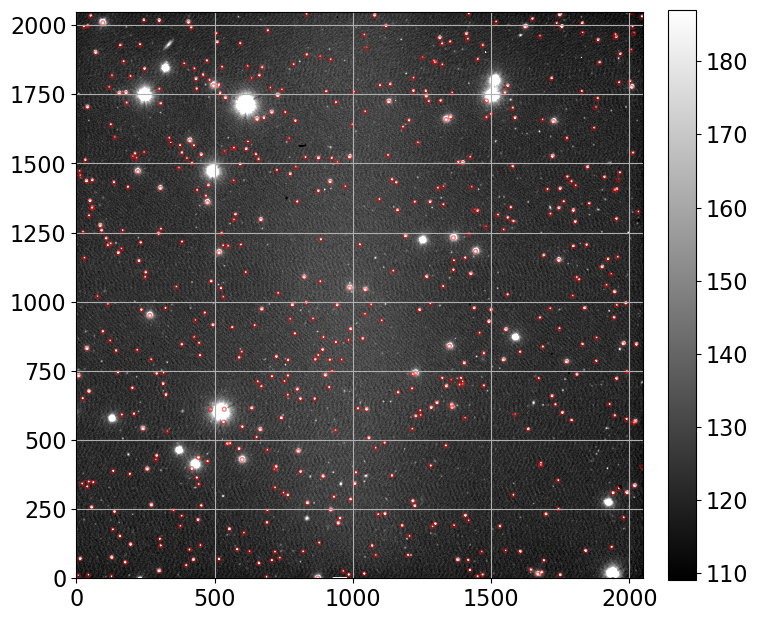

In [75]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
aps = CircularAperture(positions,r=7.0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(data, cmap='gray', ax=ax, fig=fig)

aps.plot(color='red',lw=1,alpha=0.5)
plt.show()